## MLC HW 4

### Question 1 (40 points)

In this question, you will model traffic counts in Pittsburgh using Gaussian process (GP) regression.  The included dataset, "PittsburghTrafficCounts.csv", represents the average daily traffic counts computed by traffic sensors at over 1,100 locations in Allegheny County, PA.  The data was collected from years 2012-2014 and compiled by Carnegie Mellon University’s Traffic21 Institute; we have the longitude, latitude, and average daily count for each sensor.  

Given this dataset, your goal is to learn a model of traffic count as a function of spatial location.  To do so, fit a Gaussian Process regression model to the observed data.  While you can decide on the precise kernel specification, you should try to achieve a good model fit, as quantified by a log marginal likelihood value greater than (i.e., less negative than) -1400.  Here are some hints for getting a good model fit:

* We recommend that you take the logarithm of the traffic counts, and then subtract the mean of this vector, before fitting the model.

* Since the data is noisy, don't forget to include a noise term (WhiteKernel) in your model.

* When fitting a GP with RBF kernel on multidimensional data, you can learn a separate length scale for each dimension, e.g., length_scale=(length_scale_x, length_scale_y). 

Your Python code should provide the following five outputs:

1) The kernel after parameter optimization and fitting to the observed data. (10 pts)

2) The log marginal likelihood of the training data. (5 pts)

3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values). (10 pts)

4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location? (5 pts)

5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10 pts)


In [61]:
import pandas as pd
import numpy as np
import math
Data1=pd.read_csv("PittsburghTrafficCounts.csv")
Data1.head(10)

,Longitude,Latitude,AvgDailyTrafficCount
0,-80.278366,40.468606,84.0
1,-80.162117,40.384598,95.0
2,-80.221205,40.366778,97.0
3,-80.142455,40.622084,111.0
4,-80.131975,40.544915,125.0
5,-80.139674,40.623590,126.0
6,-79.813385,40.583852,134.0
7,-80.132048,40.537038,136.0
8,-80.278168,40.466386,136.0
9,-80.138849,40.591467,141.0


In [62]:
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel

In [63]:
X = Data1.iloc[:,:2]
y = Data1.iloc[:,-1]
logy = np.log(y)
y = logy - logy.mean()
y

0      -3.977526
1      -3.854466
2      -3.833632
3      -3.698812
4      -3.580029
          ...   
1110    1.096755
1111    1.117757
1112    1.125674
1113    1.150681
1114    1.200170
Name: AvgDailyTrafficCount, Length: 1115, dtype: float64

In [64]:
Data1['logavgtraffic'] = y
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount,logavgtraffic
0,-80.278366,40.468606,84.0,-3.977526
1,-80.162117,40.384598,95.0,-3.854466
2,-80.221205,40.366778,97.0,-3.833632
3,-80.142455,40.622084,111.0,-3.698812
4,-80.131975,40.544915,125.0,-3.580029


### 1) The kernel after parameter optimization and fitting to the observed data.

In [65]:
kernel = 1* RBF(length_scale = (1.,1.), length_scale_bounds = (1e-3, 1e3))\
    + WhiteKernel(noise_level=1.,  noise_level_bounds=(1e-3, 1e3))
gp = GaussianProcessRegressor(kernel=kernel, random_state=123)

In [66]:
gp.fit(X,y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * RBF(length_scale=[1, 1]) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=123)

In [67]:
y_pred, sigma = gp.predict(X, return_std=True)

In [68]:
print('The kernel after parameter optimization and fitting is \n{}'.format(gp.kernel_))

The kernel after parameter optimization and fitting is 
0.658**2 * RBF(length_scale=[0.0326, 0.0395]) + WhiteKernel(noise_level=0.568)


In [69]:
y_pred

array([-1.59211776, -0.8003362 , -1.28812414, ...,  0.5113557 ,
        0.28981815,  0.66345558])

### 2) The log marginal likelihood of the training data. (5 pts)

In [70]:
print('The log marginal likelihood is {}'.format(gp.log_marginal_likelihood_value_))

The log marginal likelihood is -1365.323931477893


### 3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values). (10 pts)

In [71]:
min_long = Data1['Longitude'].min()
max_long = Data1['Longitude'].max()
min_lat = Data1['Latitude'].min()
max_lat = Data1['Latitude'].max()

from scipy.interpolate import griddata
import pylab as plt

In [72]:
numcols, numrows = 1115, 1115
xi = np.linspace(min_long, max_long, numcols)
yi = np.linspace(min_lat, max_lat, numrows)
xi, yi = np.meshgrid(xi, yi)

x, y, z = Data1['Longitude'].values, Data1['Latitude'].values, Data1['AvgDailyTrafficCount'].values
zi = griddata(x, y, z, xi, yi)

fig, ax = plt.subplots()
im = ax.contourf(xi, yi, zi)
ax.scatter(Data1['Longitude'], Data1['Latitude'], c = Data1['AvgDailyTrafficCount'], s=100,
           vmin=zi.min(), vmax=zi.max())
fig.colorbar(im)

plt.show()

/opt/anaconda3/lib/python3.7/site-packages/scipy/interpolate/ndgriddata.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ndim == 1 and method in ('nearest', 'linear', 'cubic'):
/opt/anaconda3/lib/python3.7/site-packages/scipy/interpolate/ndgriddata.py:217: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif method == 'nearest':
/opt/anaconda3/lib/python3.7/site-packages/scipy/interpolate/ndgriddata.py:220: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif method == 'linear':
/opt/anaconda3/lib/python3.7/site-packages/scipy/interpolate/ndgriddata.py:224: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif method == 'cubic' and ndim == 2:


ValueError: Unknown interpolation method array([[-80.31494883, -80.31438058, -80.31381233, ..., -79.68305488,
        -79.68248663, -79.68191838],
       [-80.31494883, -80.31438058, -80.31381233, ..., -79.68305488,
        -79.68248663, -79.68191838],
       [-80.31494883, -80.31438058, -80.31381233, ..., -79.68305488,
        -79.68248663, -79.68191838],
       ...,
       [-80.31494883, -80.31438058, -80.31381233, ..., -79.68305488,
        -79.68248663, -79.68191838],
       [-80.31494883, -80.31438058, -80.31381233, ..., -79.68305488,
        -79.68248663, -79.68191838],
       [-80.31494883, -80.31438058, -80.31381233, ..., -79.68305488,
        -79.68248663, -79.68191838]]) for 1 dimensional data

### 4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location? (5 pts)


In [73]:
Data1['Pred'] = y_pred

In [74]:
Data1.describe()

,Longitude,Latitude,AvgDailyTrafficCount,logavgtraffic,Pred
count,1115.000000,1115.000000,1115.000000,1.115000e+03,1115.000000
mean,-79.981176,40.457091,6042.008595,-9.283257e-15,0.007772
std,0.134905,0.101651,3542.316093,9.454420e-01,0.527325
min,-80.314949,40.198900,84.000000,-3.977526e+00,-2.064946
25%,-80.076972,40.389575,3029.250000,-3.922735e-01,-0.156381
50%,-79.975952,40.448163,5938.000000,2.807851e-01,0.149423
75%,-79.876250,40.524706,9241.000000,7.230627e-01,0.355258
max,-79.681918,40.681718,14891.000000,1.200170e+00,0.731923


In [75]:
below = (Data1.Pred.where(Data1.Pred>Data1.Pred.mean()- 2* Data1.Pred.std())).count()

In [76]:
below/Data1.shape[0]

0.9381165919282511

### 5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10 pts)


### Question 2: Cluster-based anomaly detection (10 points)

Given an unlabeled dataset with two real-valued attributes, we perform cluster-based anomaly detection by running k-means, choosing the number of clusters k automatically using the Schwarz criterion.  Four clusters are formed:

A: 100 points, center (0, 0), standard deviation 0.1

B: 150 points, center (35, 5), standard deviation 5

C: 2 points, center (15, 20), standard deviation 1

D: 200 points, center (10, 10), standard deviation 1

Given the four points below, which of these points are, and are not, likely to be anomalies?  Choose “Anomaly” or “Not Anomaly”, and provide a brief explanation, for each point. 
(Hint: your answers should take into account the size and standard deviation of each cluster as well as the distances to cluster centers.)

(1, 0)		Anomaly / Not Anomaly


(35, 2)		Anomaly / Not Anomaly


(15, 19)	Anomaly / Not Anomaly


(10, 11)	Anomaly / Not Anomaly


## Given 4 clusters:
## (1,0): Anomaly, because it is not a good fit for any of the clusters. It is the closest to cluster A, which is very dense in size. However, the fact that its standard deviation is 0.1 makes this point way too far from cluster center A. It is indeed more than 4 standard deviations above all cluster centers.
## (35,2): Not Anomaly. It is less than 4 standard deviation away from Cluster Center B, which is the closest cluster. On top of this, this cluster is very dense in size, making this point normal.
## (15,19): Anomaly, because it is the closest to cluster, which might not be a real cluster given it has only 2 points compared to the other clusters that are very dense.  It is also not a good fit for the other clusters, because it is more than 4 standard deviations away from the other cluster cents.
## (10,11): Not Anomaly. It is less than 4 standard deviations away from Cluster Center C, which is the closest center. On top of this, this cluster is very dense in size, making this point normal.

### Question 3: Anomaly detection (50 points)

For this question, use the "County Health Indicators" dataset provided to identify the most anomalous counties. Please list the top 5 most anomalous counties computed using each of the following models.  (We recommend that, as a pre-processing step, you drop na values, and make sure all numeric values are treated as floats not strings.)

Part 1: Learn a Bayesian network structure using only the six features ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"].  Use pd.cut() to discretize each feature into 5 categories: 0,1,2,3,4. 

(a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5 pts) 

(b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10 pts)

Part 2: Cluster based anomaly detection.  Use all numeric features for this part, and do not discretize. 

(a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10 pts)

(b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10 pts)

Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose.  (10 pts)

Part 4: Compare and contrast the results from the different models.  Were there some counties that were found to be anomalous in some models and not in others?  Please provide some intuitions on why each county was found to be anomalous. (5 pts)

In [77]:
Data2=pd.read_csv("2016CountyHealthIndicators.csv")
Data2.head()

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,"Autauga, Alabama",19,4.4,4.3,9,19,31,7.1,29,71,...,18,4.3,27,13.8,254,76,12.9,14,89,42
1,"Baldwin, Alabama",16,4.1,4.2,9,19,27,7.6,25,72,...,20,4.5,28,12.0,221,70,13.1,15,84,37
2,"Barbour, Alabama",26,4.9,4.7,12,21,41,5.1,33,45,...,38,5.3,54,8.1,147,64,12.6,18,84,35
3,"Bibb, Alabama",22,4.8,4.6,12,21,40,7.4,33,33,...,27,4.3,32,9.8,236,75,12.9,13,84,46
4,"Blount, Alabama",21,4.6,4.5,7,19,32,8.3,29,26,...,24,4.1,28,8.5,219,89,12.7,12,85,59


In [78]:
Data2 = Data2.replace({'?':np.nan}).dropna()
Data2.dropna(subset = ['County'], inplace = True)

In [79]:
county = Data2.County

In [80]:
Data2 = Data2.iloc[:,1:].astype(float)

In [81]:
data = pd.merge(pd.Series(county),Data2, right_index = True, left_index = True)
data.head()

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,"Autauga, Alabama",19.0,4.4,4.3,9.0,19.0,31.0,7.1,29.0,71.0,...,18.0,4.3,27.0,13.8,254.0,76.0,12.9,14.0,89.0,42.0
1,"Baldwin, Alabama",16.0,4.1,4.2,9.0,19.0,27.0,7.6,25.0,72.0,...,20.0,4.5,28.0,12.0,221.0,70.0,13.1,15.0,84.0,37.0
2,"Barbour, Alabama",26.0,4.9,4.7,12.0,21.0,41.0,5.1,33.0,45.0,...,38.0,5.3,54.0,8.1,147.0,64.0,12.6,18.0,84.0,35.0
3,"Bibb, Alabama",22.0,4.8,4.6,12.0,21.0,40.0,7.4,33.0,33.0,...,27.0,4.3,32.0,9.8,236.0,75.0,12.9,13.0,84.0,46.0
4,"Blount, Alabama",21.0,4.6,4.5,7.0,19.0,32.0,8.3,29.0,26.0,...,24.0,4.1,28.0,8.5,219.0,89.0,12.7,12.0,85.0,59.0


In [82]:
data.shape

(2486, 31)

# Part 1: Learn a Bayesian network structure using only the six features ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"].  Use pd.cut() to discretize each feature into 5 categories: 0,1,2,3,4.

In [83]:
data1 = data[["County","'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"]].copy()
data1.head()

,County,'\% Smokers','\% Obese','Violent Crime Rate','80/20 Income Ratio','\% Children in Poverty','Average Daily PM2.5'
0,"Autauga, Alabama",19.0,31.0,254.0,4.3,18.0,12.9
1,"Baldwin, Alabama",19.0,27.0,221.0,4.5,20.0,13.1
2,"Barbour, Alabama",21.0,41.0,147.0,5.3,38.0,12.6
3,"Bibb, Alabama",21.0,40.0,236.0,4.3,27.0,12.9
4,"Blount, Alabama",19.0,32.0,219.0,4.1,24.0,12.7


In [84]:
for i in data1.iloc[:,1:]:
    data1[i] = pd.qcut(data1[i], q = 5, labels=False)

In [85]:
data1.head()

,County,'\% Smokers','\% Obese','Violent Crime Rate','80/20 Income Ratio','\% Children in Poverty','Average Daily PM2.5'
0,"Autauga, Alabama",2,2,2,1,1,3
1,"Baldwin, Alabama",2,0,2,2,1,3
2,"Barbour, Alabama",3,4,1,4,4,3
3,"Bibb, Alabama",3,4,2,1,3,3
4,"Blount, Alabama",2,2,2,1,2,3


In [86]:
data1.shape

(2486, 7)

### (a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5 pts) 


In [87]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BicScore
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator

In [88]:
data_hc = data1.iloc[:,1:]
hc = HillClimbSearch(data_hc, scoring_method = BicScore(data_hc))
best_model = hc.estimate()
print(best_model.edges())

[("'\\% Smokers'", "'\\% Obese'"), ("'\\% Smokers'", "'\\% Children in Poverty'"), ("'\\% Smokers'", "'Average Daily PM2.5'"), ("'80/20 Income Ratio'", "'Violent Crime Rate'"), ("'\\% Children in Poverty'", "'80/20 Income Ratio'")]


In [89]:
model = BayesianModel(best_model.edges())
model.fit(data_hc, estimator = MaximumLikelihoodEstimator)
for cpd in model.get_cpds():
    print("CPD of {variable}:".format(variable = cpd.variable))
    print(cpd)

CPD of '80/20 Income Ratio':
+--------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+
| '\% Children in Poverty' | '\% Children in Poverty'(0) | '\% Children in Poverty'(1) | '\% Children in Poverty'(2) | '\% Children in Poverty'(3) | '\% Children in Poverty'(4) |
+--------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+
| '80/20 Income Ratio'(0)  | 0.5103969754253308          | 0.344294003868472           | 0.13837638376383765         | 0.08888888888888889         | 0.04017857142857143         |
+--------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+
| '80/20 Income Ratio'(1)  | 0.2627599243856333          | 0.235976789168278

In [90]:
def LL(x,model,verbose=False):
    loglike = 0
    for cpd in model.get_cpds():
        temp_cpd = cpd.copy()
        thevariable = temp_cpd.variable
        theparents = model.predecessors(thevariable)
        for parent in theparents:
            temp_cpd.reduce([(parent, x[parent])])
        theprob = temp_cpd.get_values()[x[thevariable],0]
        if verbose:
            print(thevariable,theparents,theprob)
        loglike += np.log(theprob)
    return loglike

In [91]:
exmp = data_hc.apply(lambda x: LL(x,model),axis=1)
exmp.min()

-14.028248031369452

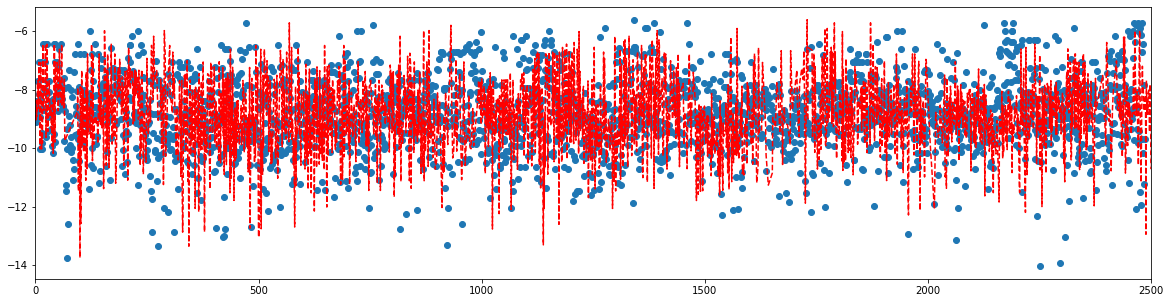

In [92]:
import matplotlib.pylab as plt
plt.figure(figsize=(20,5))
plt.scatter(range(len(exmp)),exmp)
plt.plot(exmp,"r--")
plt.xlim(0, 2500)
plt.show()

### (b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10 pts)

In [93]:
top5 = pd.Series(exmp)
top5.index = data1.County
top5.sort_values().head()

County
Montgomery, Virginia          -14.028248
Harrisonburg City, Virginia   -13.929264
La Paz, Arizona               -13.743477
Highlands, Florida            -13.348434
Lafayette, Louisiana          -13.302995
dtype: float64

# Part 2: Cluster based anomaly detection.  Use all numeric features for this part, and do not discretize.

In [94]:
data.head()

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,"Autauga, Alabama",19.0,4.4,4.3,9.0,19.0,31.0,7.1,29.0,71.0,...,18.0,4.3,27.0,13.8,254.0,76.0,12.9,14.0,89.0,42.0
1,"Baldwin, Alabama",16.0,4.1,4.2,9.0,19.0,27.0,7.6,25.0,72.0,...,20.0,4.5,28.0,12.0,221.0,70.0,13.1,15.0,84.0,37.0
2,"Barbour, Alabama",26.0,4.9,4.7,12.0,21.0,41.0,5.1,33.0,45.0,...,38.0,5.3,54.0,8.1,147.0,64.0,12.6,18.0,84.0,35.0
3,"Bibb, Alabama",22.0,4.8,4.6,12.0,21.0,40.0,7.4,33.0,33.0,...,27.0,4.3,32.0,9.8,236.0,75.0,12.9,13.0,84.0,46.0
4,"Blount, Alabama",21.0,4.6,4.5,7.0,19.0,32.0,8.3,29.0,26.0,...,24.0,4.1,28.0,8.5,219.0,89.0,12.7,12.0,85.0,59.0


In [95]:
data2 = data.copy()
data2.head()

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,"Autauga, Alabama",19.0,4.4,4.3,9.0,19.0,31.0,7.1,29.0,71.0,...,18.0,4.3,27.0,13.8,254.0,76.0,12.9,14.0,89.0,42.0
1,"Baldwin, Alabama",16.0,4.1,4.2,9.0,19.0,27.0,7.6,25.0,72.0,...,20.0,4.5,28.0,12.0,221.0,70.0,13.1,15.0,84.0,37.0
2,"Barbour, Alabama",26.0,4.9,4.7,12.0,21.0,41.0,5.1,33.0,45.0,...,38.0,5.3,54.0,8.1,147.0,64.0,12.6,18.0,84.0,35.0
3,"Bibb, Alabama",22.0,4.8,4.6,12.0,21.0,40.0,7.4,33.0,33.0,...,27.0,4.3,32.0,9.8,236.0,75.0,12.9,13.0,84.0,46.0
4,"Blount, Alabama",21.0,4.6,4.5,7.0,19.0,32.0,8.3,29.0,26.0,...,24.0,4.1,28.0,8.5,219.0,89.0,12.7,12.0,85.0,59.0


In [96]:
data2.isnull().sum()

County                                   0
'\% Reporting Fair/Poor Health'          0
'Physically Unhealthy Days Per Month'    0
'Mentally Unhealthy Days Per Month'      0
'\% Low birth weight births'             0
'\% Smokers'                             0
'\% Obese'                               0
'Food Environment Index'                 0
'\% Physically Inactive'                 0
'\% With Access To Exercise'             0
'\% Excessive Drinking'                  0
'\% Alcohol-Impaired Driving Deaths'     0
'Chlamydia Rate'                         0
'Teen Birth Rate'                        0
'\% Uninsured'                           0
'Preventable Hosp. Rate'                 0
'\% Dibetics receiving HbA1c'            0
'\% Mammography'                         0
'Graduation Rate'                        0
'\% Some College'                        0
'\% Unemployed'                          0
'\% Children in Poverty'                 0
'80/20 Income Ratio'                     0
'\% Single-

In [97]:
data2.shape

(2486, 31)

### (a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10 pts)


In [98]:
from sklearn.cluster import KMeans
KM = KMeans(n_clusters = 3,random_state = 999)
X = data2.iloc[:,1:]
score = KM.fit_predict(X)

# distance to each cluster center
res = pd.DataFrame(KM.transform(X))
res.head()

,0,1,2
0,215.546368,554.609617,101.895485
1,108.370262,655.932344,186.335226
2,410.503731,530.643663,282.291939
3,168.209200,602.378878,141.457457
4,105.075152,777.335076,315.009861


In [99]:
# add cluster and distance information for each data record
res=pd.DataFrame(KM.transform(X))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(X))),axis=1)
res.columns=list(range(3))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

# find data records farthest from cluster centers
res.head()

,0,1,2,cluster,score
0,215.546368,554.609617,101.895485,2,101.895485
1,108.370262,655.932344,186.335226,0,108.370262
2,410.503731,530.643663,282.291939,2,282.291939
3,168.209200,602.378878,141.457457,2,141.457457
4,105.075152,777.335076,315.009861,0,105.075152


In [100]:
res.shape

(2486, 5)

In [101]:
county = data2.County
county.reset_index(inplace = True, drop = True)

In [102]:
res['county'] = county
res.sort_values('score', ascending = False)[:5]

,0,1,2,cluster,score,county
1890,2443.716031,1970.018443,2251.260167,1,1970.018443,"Shannon, South Dakota"
1294,2036.147297,1332.735955,1759.249198,1,1332.735955,"St. Louis City, Missouri"
96,1917.732820,1208.900834,1639.063836,1,1208.900834,"Crittenden, Arkansas"
2304,1644.876605,1017.910163,1394.632068,1,1017.910163,"Petersburg City, Virginia"
995,1651.954082,918.374430,1366.737248,1,918.374430,"Baltimore City, Maryland"


In [103]:
res['cluster'].value_counts().sort_index()

0    1426
1     246
2     814
Name: cluster, dtype: int64

### (b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10 pts)



In [104]:
from sklearn.mixture import GaussianMixture
GM=GaussianMixture(n_components=3,random_state=999)
GM.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=999, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

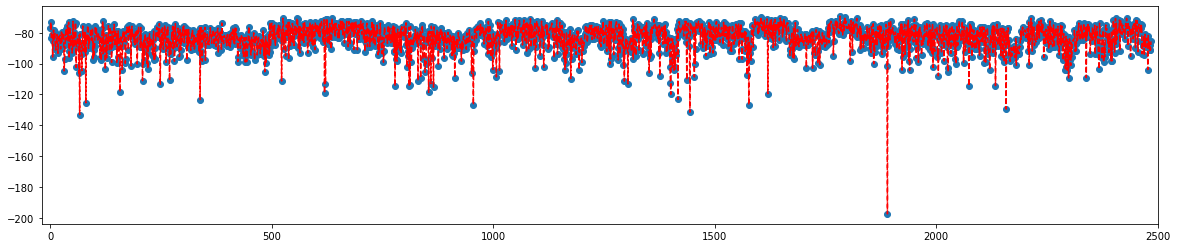

In [105]:
# score_samples function gives the log of the probability density of each data record given its cluster.
# Note that probability densities can exceed 1 (unlike probabilities of discrete data).
import matplotlib.pylab as plt
plt.figure(figsize=(20,4))
plt.scatter(range(len(X)),GM.score_samples(X))
plt.plot(GM.score_samples(X),"r--")
plt.xlim(-20, 2500)
plt.show()

In [106]:
log = pd.DataFrame(GM.score_samples(X))
log['county'] = county
# 5 most anomalous data points by log-likelihood (i.e. log probability density)
log.sort_values(0)[:5]

,0,county
1890,-197.420106,"Shannon, South Dakota"
66,-133.042814,"Apache, Arizona"
1444,-131.452092,"New York, New York"
2158,-129.450559,"Willacy, Texas"
1577,-126.696033,"Roulette, North Dakota"


### Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose.  (10 pts)



In [107]:
data3 = data2.copy()
data3.head()

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,"Autauga, Alabama",19.0,4.4,4.3,9.0,19.0,31.0,7.1,29.0,71.0,...,18.0,4.3,27.0,13.8,254.0,76.0,12.9,14.0,89.0,42.0
1,"Baldwin, Alabama",16.0,4.1,4.2,9.0,19.0,27.0,7.6,25.0,72.0,...,20.0,4.5,28.0,12.0,221.0,70.0,13.1,15.0,84.0,37.0
2,"Barbour, Alabama",26.0,4.9,4.7,12.0,21.0,41.0,5.1,33.0,45.0,...,38.0,5.3,54.0,8.1,147.0,64.0,12.6,18.0,84.0,35.0
3,"Bibb, Alabama",22.0,4.8,4.6,12.0,21.0,40.0,7.4,33.0,33.0,...,27.0,4.3,32.0,9.8,236.0,75.0,12.9,13.0,84.0,46.0
4,"Blount, Alabama",21.0,4.6,4.5,7.0,19.0,32.0,8.3,29.0,26.0,...,24.0,4.1,28.0,8.5,219.0,89.0,12.7,12.0,85.0,59.0


In [108]:
X = data3.iloc[:,1:]
y = data3.iloc[:,1]

In [109]:
data3.describe()

,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise','\% Excessive Drinking',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
count,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,...,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000
mean,17.203942,3.865809,3.753097,8.222446,18.569992,31.022928,7.093242,27.162108,63.002011,16.604988,...,23.844730,4.545133,33.345937,12.731175,267.538616,74.454545,11.720072,14.958568,80.197908,30.881738
std,4.856641,0.715394,0.581101,1.971016,3.646631,4.524278,1.069392,5.554257,22.020285,3.420385,...,8.692791,0.695486,9.383930,4.981697,198.532609,21.554035,1.535203,4.277249,5.945515,11.935865
min,7.000000,2.200000,2.100000,3.000000,7.000000,11.000000,0.500000,9.000000,0.000000,9.000000,...,3.000000,2.700000,1.000000,1.000000,0.000000,25.000000,7.200000,5.000000,6.000000,3.000000
25%,13.000000,3.400000,3.300000,7.000000,16.000000,29.000000,6.500000,24.000000,48.000000,14.000000,...,17.250000,4.100000,27.000000,9.300000,128.000000,60.000000,10.600000,12.000000,78.000000,22.000000
50%,16.000000,3.800000,3.800000,8.000000,18.000000,31.000000,7.200000,27.000000,65.000000,17.000000,...,23.000000,4.400000,33.000000,12.100000,216.000000,72.000000,12.000000,14.000000,81.000000,30.000000
75%,20.000000,4.400000,4.100000,9.000000,21.000000,34.000000,7.800000,31.000000,80.000000,19.000000,...,29.000000,4.900000,38.000000,15.500000,356.750000,87.000000,13.000000,17.000000,84.000000,39.000000
max,42.000000,6.500000,5.600000,19.000000,41.000000,46.000000,10.000000,42.000000,100.000000,27.000000,...,54.000000,8.700000,76.000000,41.000000,1885.000000,200.000000,14.900000,44.000000,95.000000,72.000000


In [110]:
from sklearn.ensemble import IsolationForest

In [111]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
scaler.fit(X)
X3 = pd.DataFrame(data = scaler.transform(X))
pca = PCA(n_components = 2)
X3 = pca.fit_transform(X3)
X3

array([[ 0.28402602, -1.08959478],
       [-0.52357938, -0.0279797 ],
       [ 5.57299675,  0.46251951],
       ...,
       [-0.76531161, -0.83703899],
       [-2.0815728 , -0.21226248],
       [-2.20245663, -0.90716049]])

In [112]:
# scaler.fit(X_test)
# X_test = pd.DataFrame(data = scaler.transform(X_test))
# # pca = PCA(n_components = 2)
# X_test = pca.fit_transform(X_test)

In [113]:
# fit the model
clf = IsolationForest(max_samples=100, random_state = np.random.RandomState(42))
clf.fit(X3)
y_pred = clf.predict(X3)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [114]:
X['anomaly'] = y_pred
out = X[X['anomaly'] == -1]
out['county']=county
out = out.dropna()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [115]:
X['anomaly'].value_counts()

 1    2237
-1     249
Name: anomaly, dtype: int64

In [116]:
# plt.figure(figsize=(10,10))

# plt.title("IsolationForest")
# plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

# b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white')
# b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green')
# plt.axis('tight')
# plt.xlim((-5, 5))
# plt.ylim((-5, 5))
# plt.legend([b1, b2],
#            ["training observations",
#             "predictions"],
#            loc="upper left")
# plt.show()

### Part 4: Compare and contrast the results from the different models.  Were there some counties that were found to be anomalous in some models and not in others?  Please provide some intuitions on why each county was found to be anomalous. (5 pts)

## The top 5 most anomalous counties according to each of the following models are:
### 1. Bayesian Network: Montgomery, Virginia - Harrisonburg City, Virginia - La Paz, Arizona - Highlands, Florida - Lafayette, Louisiana  
### 2. Clustering with k-means: Shannon, South Dakota - St. Louis City, Missour - Crittenden, Arkansas - Petersburg City, Virginia - Baltimore City, Maryland
### 3. Clustering with Gaussian Mixture: Shannon, South Dakota - Apache, Arizona - New York, New York - Willacy, Texas - Roulette, North Dakota
### 4. Isolation Forest: 249 anomalous counties

## Clustering has yield similar results in terms of the most anomalous county which is Shannon South Dakota. For Clustering with k-means, those counties were found to be anomalous as they were the furthest from all cluster centers. For Clustering with Gaussian Mixture, these counties were classified as the most anomalous ones because they are from the most dense clusters . For Bayesian Network, these counties had the highest probablity of being misclassified, which might probably due to lack of data for these specific counties to properly classify them. Finally, isolation forest yielded a high number of anomalous values